In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import os
import pandas as pd

In [3]:
loc = 'nw2'
turbine = 'c02'

In [17]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected.set_index('timestamp', inplace=True)
ss2_selected.index = pd.to_datetime(ss2_selected.index, utc=True)

SS1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS1_mode.parquet'))
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
FA1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA1_mode.parquet'))
FA2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA2_mode.parquet'))

In [21]:
from src.data.utils import get_input_data
from src.data.harmonics import *

data = {}
data['turbine_data'] = pd.read_parquet(os.path.join(data_folder, 'raw', loc, 'big_data', loc + turbine + '_big_data.parquet'))
data['mvbc_data'] = pd.read_parquet(os.path.join(data_folder, 'external', loc, 'mvbc_data.parquet'))

harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

wandelaar_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_wandelaar_weather_data.parquet'))
westhinder_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_westhinder_weather_data.parquet'))

mvbc_test_data = wandelaar_weather_station_data.copy()
mvbc_test_data[mvbc_test_data.filter(regex='Tide').columns] = westhinder_weather_station_data.filter(regex='Tide').values
#mvbc_test_data.rename(columns={mvbc_test_data.filter(regex='Tide').columns[0] :westhinder_weather_station_data.filter(regex='Tide').columns[0]}, inplace=True)
mvbc_test_data.isna().sum()
mvbc_test_data.index = pd.to_datetime(mvbc_test_data.index, utc=True)

scada_data = data['turbine_data'].filter(regex='mean_').filter(regex='rpm|yaw|pitch|power|windspeed|winddirection')
print('scada data availability (%)')
print(1 - scada_data.isna().sum()/len(scada_data))

mvbc_data = pd.concat([data['mvbc_data'], mvbc_test_data], axis=0)
mvbc_data = mvbc_data[~mvbc_data.index.duplicated(keep='first')]
print('mvbc data availability (%)')
print(1 - mvbc_data.isna().sum()/len(mvbc_data))

scada data availability (%)
mean_NW2_C02_rpm              0.97398
mean_NW2_C02_yaw              0.97398
mean_NW2_C02_pitch            0.97398
mean_NW2_C02_power            0.97398
mean_NW2_C02_windspeed        0.97398
mean_NW2_C02_winddirection    0.97398
dtype: float64
mvbc data availability (%)
mvbc_WandelaarBuoy_10%_highest_waves                                    1.000000
mvbc_WandelaarBuoy_Wave_height                                          1.000000
mvbc_WandelaarBuoy_Average_wave_period                                  1.000000
mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s                      1.000000
mvbc_WandelaarBuoy_Sea_water_temperature                                0.941740
mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)    0.999970
mvbc_WandelaarMeasuringpile_Average_wind_direction                      1.000000
mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)         0.999970
mvbc_WandelaarMeasuringpile_Tide_TAW                  

Availability:  0.07397164521569997
Selected features: Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_winddirection'],
      dtype='object')
Removed features:  Index(['mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Air_temperature',
       'mean_NW2_C02_windspeed'],
      dtype='object')
Feature ranking: [1 1 5 7 1 8 4 6 1 1 3 1 1 1 1 2 1]
ordered features:  Index(['mvbc_WandelaarBuoy_10%_hi

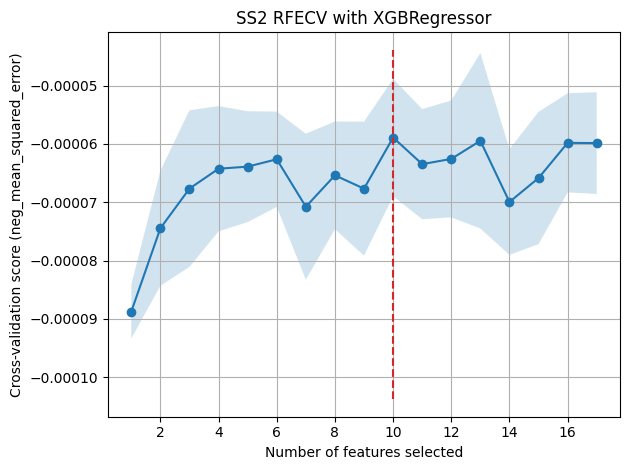

In [31]:
from sklearn.model_selection import train_test_split
X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]


#ss2_selected.set_index('timestamp', inplace=True)
#ss2_selected.index = pd.to_datetime(ss2_selected.index, utc=True)

y_ = ss2_selected['mean_frequency']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xy = pd.DataFrame(y_)
for col in X_.columns:
    Xy[col] = X_[col]
Xy = Xy.dropna()
y = Xy[y_.name]
X = Xy[X_.columns]

y_unique = y_[~y_.index.duplicated(keep='first')].dropna()
print('Availability: ', len(y_unique)/len(X_))

from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
regr_model = XGBRegressor()
cv = KFold(5)
selector = RFECV(
    regr_model,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=1,
    n_jobs=2,
)
selector = selector.fit(X, y)

selected_features = selector.support_
ranking = selector.ranking_

print("Selected features:", X.columns[selected_features])
print("Removed features: ", X.columns[~selected_features])
print("Feature ranking:", ranking)
print('ordered features: ', X.columns[ranking.argsort()])

import matplotlib.pyplot as plt
import numpy as np
# Assuming 'selector' is your RFECV object
n_scores = len(selector.cv_results_["mean_test_score"])
min_features_to_select = 1  # as defined in your RFECV setup

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg_mean_squared_error)")
plt.plot(range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    color='tab:blue',
    marker = 'o'
)
plt.fill_between(range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"] - selector.cv_results_["std_test_score"],
    selector.cv_results_["mean_test_score"] + selector.cv_results_["std_test_score"], alpha=0.2)
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     selector.cv_results_["mean_test_score"],
#     yerr=selector.cv_results_["std_test_score"] if 'std_test_score' in selector.cv_results_ else None,
#     color='tab:blue'
# )
plt.vlines(selector.n_features_,
           ymin=selector.cv_results_['mean_test_score'].min() - selector.cv_results_["std_test_score"].max(),
           ymax=selector.cv_results_['mean_test_score'].max() + selector.cv_results_["std_test_score"].max(),
           color='tab:red', linestyle='--')
plt.grid()
plt.title("SS2 RFECV with XGBRegressor")
plt.tight_layout()
#plt.yticks(np.linspace(-4e-5, -11e-5, 8), [''.format(x) for x in np.linspace(-4e-5, -11e-5, 8)])
plt.show()

selected_data = X_[X.columns[selected_features]]
selected_data.to_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

Availability:  0.8653527632998526
Selected features: Index(['mean_NW2_C02_pitch', 'mean_NW2_C02_windspeed'], dtype='object')
Removed features:  Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_power', 'mean_NW2_C02_winddirection'],
      dtype='object')
Feature ranking: [ 4 11  6 13 10 16 14 15 12  8  3  2  9  1  5  1  7]
ordered features:  Index(['mean_NW2_C02_pitch', '

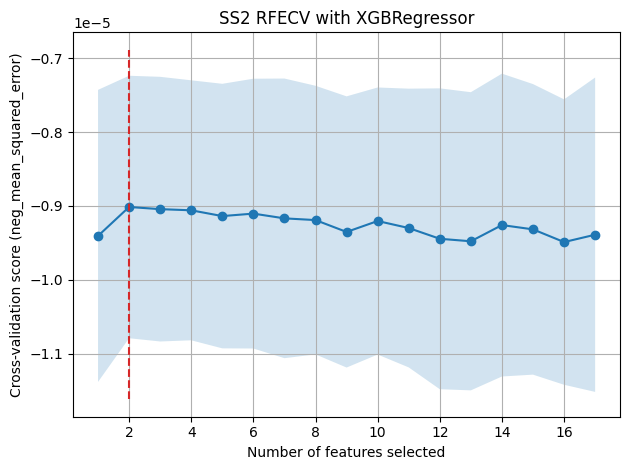

In [27]:
from sklearn.model_selection import train_test_split
X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]


#ss2_selected.set_index('timestamp', inplace=True)
#ss2_selected.index = pd.to_datetime(ss2_selected.index, utc=True)

y_ = SS1_dbscan['mean_frequency']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xy = pd.DataFrame(y_)
for col in X_.columns:
    Xy[col] = X_[col]
Xy = Xy.dropna()
y = Xy[y_.name]
X = Xy[X_.columns]

y_unique = y_[~y_.index.duplicated(keep='first')].dropna()
print('Availability: ', len(y_unique)/len(X_))

from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, KFold

regr_model = XGBRegressor()
cv = KFold(10)
selector = RFECV(
    regr_model,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=1,
    n_jobs=2,
)
selector = selector.fit(X, y)

selected_features = selector.support_
ranking = selector.ranking_

print("Selected features:", X.columns[selected_features])
print("Removed features: ", X.columns[~selected_features])
print("Feature ranking:", ranking)
print('ordered features: ', X.columns[ranking.argsort()])

import matplotlib.pyplot as plt
import numpy as np
# Assuming 'selector' is your RFECV object
n_scores = len(selector.cv_results_["mean_test_score"])
min_features_to_select = 1  # as defined in your RFECV setup

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg_mean_squared_error)")
plt.plot(range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    color='tab:blue',
    marker = 'o'
)
plt.fill_between(range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"] - selector.cv_results_["std_test_score"],
    selector.cv_results_["mean_test_score"] + selector.cv_results_["std_test_score"], alpha=0.2)
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     selector.cv_results_["mean_test_score"],
#     yerr=selector.cv_results_["std_test_score"] if 'std_test_score' in selector.cv_results_ else None,
#     color='tab:blue'
# )
plt.vlines(selector.n_features_,
           ymin=selector.cv_results_['mean_test_score'].min() - selector.cv_results_["std_test_score"].max(),
           ymax=selector.cv_results_['mean_test_score'].max() + selector.cv_results_["std_test_score"].max(),
           color='tab:red', linestyle='--')
plt.grid()
plt.title("SS2 RFECV with XGBRegressor")
plt.tight_layout()
#plt.yticks(np.linspace(-4e-5, -11e-5, 8), [''.format(x) for x in np.linspace(-4e-5, -11e-5, 8)])
plt.show()

selected_data = X_[X.columns[selected_features]]
selected_data.to_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

Availability:  0.9184458052849914
Selected features: Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarMeasuringpile_Tide_TAW', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_pitch', 'mean_NW2_C02_power', 'mean_NW2_C02_windspeed'],
      dtype='object')
Removed features:  Index(['mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_C02_yaw',
       'mean_NW2_C02_winddirection'],
      dtype='object')
Feature ranking: [ 1  1  7 11  5 10  9  8  1  6  3  1  4  1  1  1  2]
ordered features:  Index(['mvbc_WandelaarBu

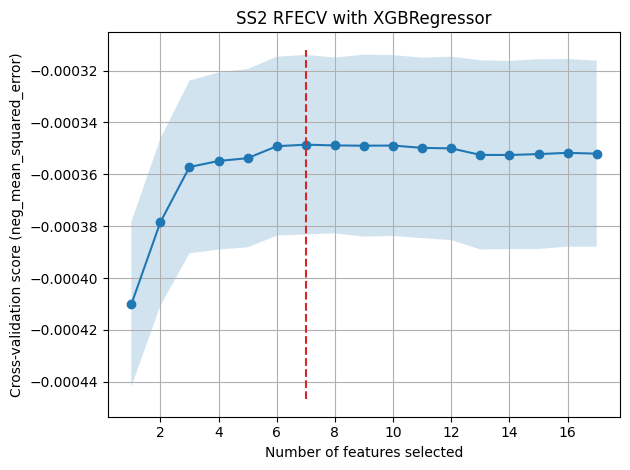

In [29]:
from sklearn.model_selection import train_test_split
X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]


#ss2_selected.set_index('timestamp', inplace=True)
#ss2_selected.index = pd.to_datetime(ss2_selected.index, utc=True)

y_ = SS2_dbscan['mean_frequency']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xy = pd.DataFrame(y_)
for col in X_.columns:
    Xy[col] = X_[col]
Xy = Xy.dropna()
y = Xy[y_.name]
X = Xy[X_.columns]

y_unique = y_[~y_.index.duplicated(keep='first')].dropna()
print('Availability: ', len(y_unique)/len(X_))

from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, KFold

regr_model = XGBRegressor()
cv = KFold(10)
selector = RFECV(
    regr_model,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=1,
    n_jobs=2,
)
selector = selector.fit(X, y)

selected_features = selector.support_
ranking = selector.ranking_

print("Selected features:", X.columns[selected_features])
print("Removed features: ", X.columns[~selected_features])
print("Feature ranking:", ranking)
print('ordered features: ', X.columns[ranking.argsort()])

import matplotlib.pyplot as plt
import numpy as np
# Assuming 'selector' is your RFECV object
n_scores = len(selector.cv_results_["mean_test_score"])
min_features_to_select = 1  # as defined in your RFECV setup

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg_mean_squared_error)")
plt.plot(range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    color='tab:blue',
    marker = 'o'
)
plt.fill_between(range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"] - selector.cv_results_["std_test_score"],
    selector.cv_results_["mean_test_score"] + selector.cv_results_["std_test_score"], alpha=0.2)
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     selector.cv_results_["mean_test_score"],
#     yerr=selector.cv_results_["std_test_score"] if 'std_test_score' in selector.cv_results_ else None,
#     color='tab:blue'
# )
plt.vlines(selector.n_features_,
           ymin=selector.cv_results_['mean_test_score'].min() - selector.cv_results_["std_test_score"].max(),
           ymax=selector.cv_results_['mean_test_score'].max() + selector.cv_results_["std_test_score"].max(),
           color='tab:red', linestyle='--')
plt.grid()
plt.title("SS2 RFECV with XGBRegressor")
plt.tight_layout()
#plt.yticks(np.linspace(-4e-5, -11e-5, 8), [''.format(x) for x in np.linspace(-4e-5, -11e-5, 8)])
plt.show()

selected_data = X_[X.columns[selected_features]]
#selected_data.to_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))